## Imports

In [155]:
import numpy as np
import matplotlib.pyplot as plt

## Generate the data

In [156]:
def draw_sequence_from_motif(motif, rng=None):
    # Initialize the random number generator if needed
    if rng is None:
        rng = np.random.default_rng()
    
    # Initialize the sequence array
    motif_length = motif.shape[0]
    motif_sequence = np.zeros(K, dtype=int)
    
    # Draw each sequence element from motif
    for k in range(motif_length):
        motif_sequence[k] = rng.choice(4, size=1, p=motif[k, :])
    return motif_sequence


In [157]:
def generate_sequences_with_single_motif(
    num_sequences,
    sequence_length,
    motif,
    rng=None,
):
    # Initialize the random number generator
    if rng is None:
        rng = np.random.default_rng()
    if type(rng) == int:
        rng = np.random.default_rng(rng)
    
    # Initialize the sequences matrix
    sequences = rng.integers(4, size=(num_sequences, sequence_length))
    
    # Draw positions for motifs
    motif_length = motif.shape[0]
    positions = rng.integers(sequence_length - motif_length + 1, size=num_sequences)
    
    # Per full sequence, draw from motif and insert
    for n in range(num_sequences):
        sequences[n, positions[n]:positions[n]+motif_length] = draw_sequence_from_motif(motif, rng)
    
    return sequences, positions



    

In [158]:
motif = np.array([
    [0.4, 0.3, 0.2, 0.1],
    [0.3, 0.3, 0.2, 0.2],
    [0.9, 0, 0, 0.1],
    [0.8, 0.1, 0.1, 0],
    [0.3, 0.3, 0.2, 0.2],
    [0.3, 0.3, 0.2, 0.2],
    [0.08, 0.01, 0.01, 0.9],
    [0, 0.2, 0, 0.8],    
])

K = motif.shape[0]
N = 90
L = 100

sequences, positions = generate_sequences_with_single_motif(N, L, motif)

## EM functions

### Calculate log-likelihood of data

In [159]:
def log_likelihood(
    sequences,
    motif
):
    # Initialize
    ll = 0.0
    num_sequences, sequence_length = sequences.shape
    motif_length = len(motif)
    max_position = sequence_length - motif_length + 1
    C = (1.0 / max_position) * (1.0/4)**(sequence_length - motif_length)
    
    # Per sequemce, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        for i in range(max_position):
            q = C
            for k in range(motif_length):
                q *= motif[k, sequences[n, i + k]] 
            p += q
        ll += np.log(p)
                        
    return ll
        

### Expectation step

In [160]:
def expectation_step(
    sequences,
    motif
):
    # Initialize
    num_sequences, sequence_length = sequences.shape
    motif_length = len(motif)   
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                likelihood *= motif[k, sequences[n, i + k]]
            positions_posterior[n, i] = likelihood
            
        # Normalize
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior
    

### Maximization step

In [407]:
def maximization_step(
    sequences,
    positions_posterior,
    motif_length,
    alpha,
):
    # Initialize
    num_sequences, sequence_length = sequences.shape
    max_position = sequence_length - motif_length + 1
    motif_estimate = np.zeros((motif_length, 4), dtype=float)   
    
    # Add dirichelt prior
    motif_estimate += alpha
    
    # Build the estimate
    for k in range(motif_length):
        for n in range(num_sequences):
            for i in range(max_position):
                # Which nucleotide is in the k-th position of the i-th k-mer 
                # in the n-th sequence?
                j = sequences[n, i+k]
                
                # Update the respective estimate
                motif_estimate[k, j] += positions_posterior[n, i]
                
        # Normalize
        motif_estimate[k, :] /= motif_estimate[k, :].sum()
                
    return motif_estimate
        
    

### EM algorithm

In [408]:
def expectation_maximization(
    sequences,
    motif_length,
    n_iterations,
    alpha=0,
    rng=None,
    print_every=None,
):
    # Initialize the random number generator
    if rng is None:
        rng = np.random.default_rng()
    if type(rng) == int:
        rng = np.random.default_rng(rng)

    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posterior_matrices = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood(sequences, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step(sequences, est_motif)
        positions_posterior_matrices.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior, motif_length, alpha)
    
    return est_motif, lls, positions_posterior_matrices

## Run it!

In [409]:
est_motif, lls, positions_posterior_matrices = expectation_maximization(sequences, K, 300, alpha=1, print_every=10)

Iteration 0: LL = -12483.745889765469
Iteration 10: LL = -12466.730740191213
Iteration 20: LL = -12463.290099229025
Iteration 30: LL = -12462.27803299153
Iteration 40: LL = -12461.54565937947
Iteration 50: LL = -12460.734474730538
Iteration 60: LL = -12459.893717595085
Iteration 70: LL = -12458.566834506688
Iteration 80: LL = -12451.873003036197
Iteration 90: LL = -12429.196078778376
Iteration 100: LL = -12426.668080330744
Iteration 110: LL = -12426.478493361232
Iteration 120: LL = -12426.454083458837
Iteration 130: LL = -12426.452729808485
Iteration 140: LL = -12426.454694751059
Iteration 150: LL = -12426.45651475974
Iteration 160: LL = -12426.457739901118
Iteration 170: LL = -12426.45848606836
Iteration 180: LL = -12426.458920880872
Iteration 190: LL = -12426.459168629188
Iteration 200: LL = -12426.45930807123
Iteration 210: LL = -12426.459386010743
Iteration 220: LL = -12426.459429399083
Iteration 230: LL = -12426.45945349608
Iteration 240: LL = -12426.45946686039
Iteration 250: LL 

### Take a look at the result vs. truth

In [410]:
with np.printoptions(precision=3, suppress=True):
    print("Truth:")
    print(motif)
    print()
    print("Estimate:")
    print(est_motif)

Truth:
[[0.4  0.3  0.2  0.1 ]
 [0.3  0.3  0.2  0.2 ]
 [0.9  0.   0.   0.1 ]
 [0.8  0.1  0.1  0.  ]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.3  0.2  0.2 ]
 [0.08 0.01 0.01 0.9 ]
 [0.   0.2  0.   0.8 ]]

Estimate:
[[0.71  0.054 0.046 0.19 ]
 [0.761 0.036 0.169 0.035]
 [0.348 0.216 0.323 0.114]
 [0.245 0.303 0.073 0.38 ]
 [0.082 0.116 0.045 0.756]
 [0.047 0.127 0.036 0.79 ]
 [0.065 0.5   0.092 0.343]
 [0.356 0.257 0.077 0.31 ]]


Text(0, 0.5, 'log likelihood')

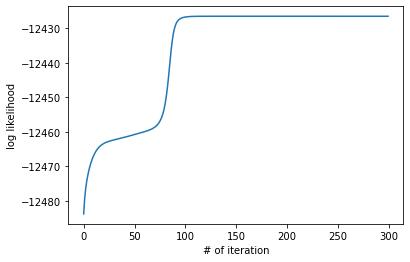

In [411]:
plt.plot(lls)
plt.xlabel("# of iteration")
plt.ylabel("log likelihood")

In [189]:
PP = np.array(positions_posterior_matrices)

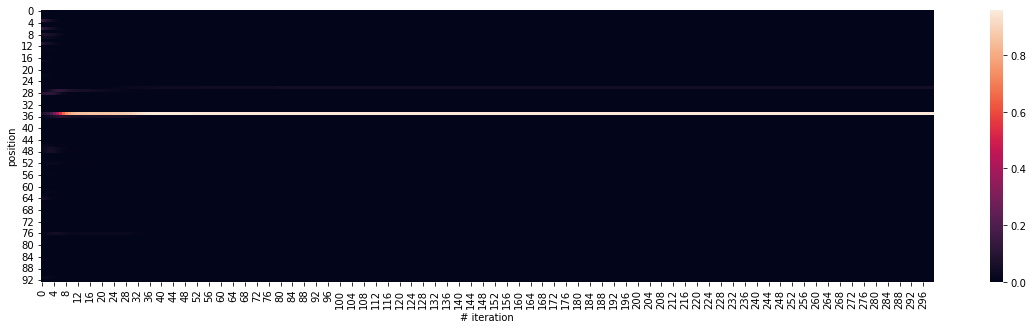

In [198]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 5))

n_sequence_to_check = 44
sns.heatmap(PP[:,n_sequence_to_check,:].T, ax=ax);
ax.set_xlabel("# iteration");
ax.set_ylabel("position");

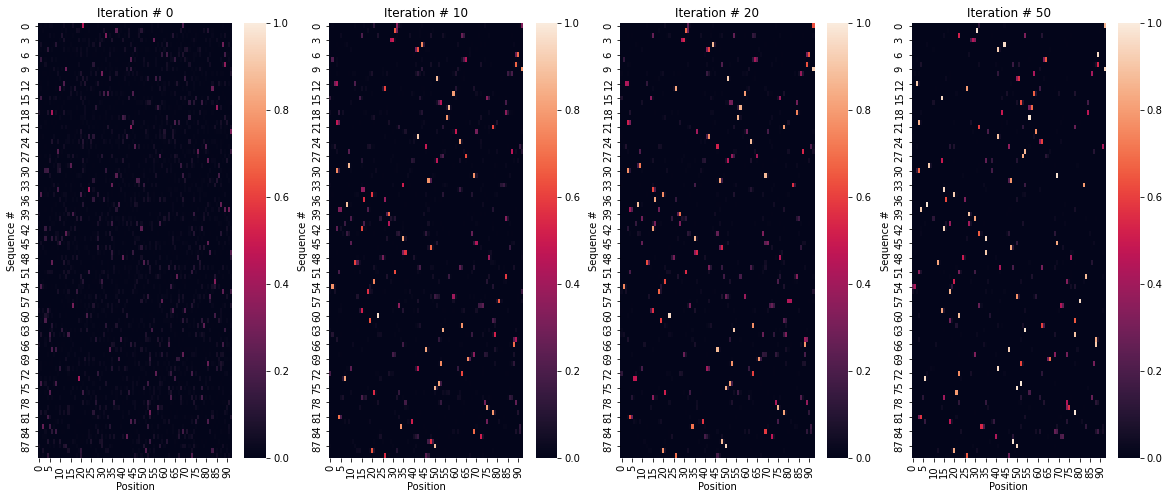

In [208]:
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(20, 8))

for ax, n_iter_to_see in zip(axs, [0, 10, 20, 50]):
    sns.heatmap(PP[n_iter_to_see,:,:], ax=ax, vmin=0, vmax=1);
    ax.set_title(f"Iteration # {n_iter_to_see}")
    ax.set_ylabel("Sequence #")
    ax.set_xlabel("Position")


## Function to draw simple logos

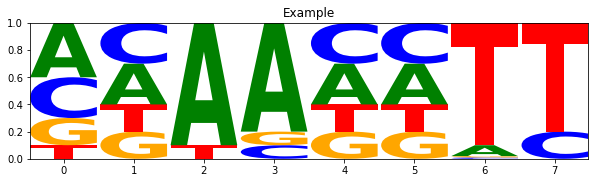

In [423]:
import logomaker
import pandas as pd
import warnings

def draw_motif(motif, title=""):
    # Make dataframe for logomake
    df = pd.DataFrame(motif, columns=["A", "C", "G", "T"])
    logo = logomaker.Logo(df)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        logo.ax.set_title(title)
        logo.fig.show()

draw_motif(motif, "Example")

## Draw motifs from Dirichlet, study convergence properties

In [219]:
def draw_motif_from_dirichlet(alpha, motif_length):
    rng = np.random.default_rng()
    return rng.dirichlet([alpha] * 4, motif_length)

### See how various alpha-s affect motif entropy

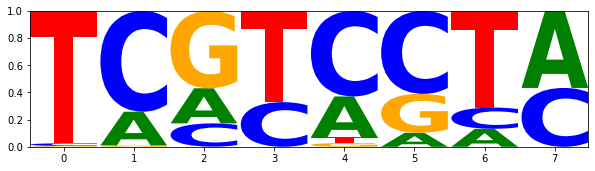

In [220]:
draw_motif(draw_motif_from_dirichlet(0.1, 8))

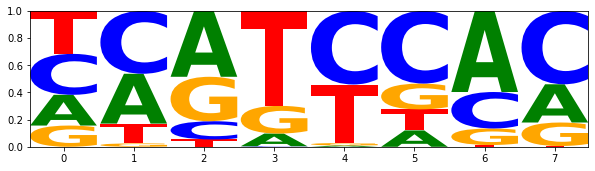

In [221]:
draw_motif(draw_motif_from_dirichlet(1, 8))

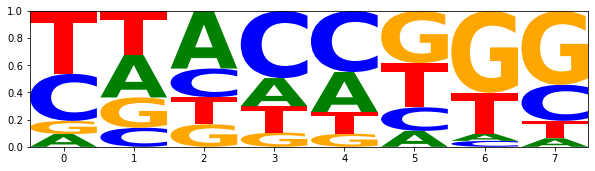

In [223]:
draw_motif(draw_motif_from_dirichlet(2, 8))

# MCMC

In [235]:
def log_likelihood_with_positions(
    sequences,
    positions,
    motif,
):
    # Initialize
    ll = 0.0
    num_sequences, sequence_length = sequences.shape
    motif_length = len(motif)
    max_position = sequence_length - motif_length + 1
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        i = positions[n]
        q = 1
        for k in range(motif_length):
            q *= motif[k, sequences[n, i + k]] 
        p += q
        ll += np.log(p)
                        
    return ll

In [250]:
def gibbs_sample_position(
    sequences,
    est_motif,
    rng,
):
    num_sequences, sequence_length = sequences.shape
    motif_length = len(est_motif)
    max_position = sequence_length - motif_length + 1

    # Draw new positions
    positions_posterior = expectation_step(sequences, est_motif)
    positions = np.zeros(len(sequences), dtype=int)
    for n in range(num_sequences):
        positions[n] = rng.choice(max_position, p=positions_posterior[n])
        
    return positions


In [251]:
def gibbs_sample_motif(
    alpha,
    sequences,
    est_positions,
    motif_length,
    rng,
):
    num_sequences, sequence_length = sequences.shape
    max_position = sequence_length - motif_length + 1
    
    # Calculate the dirichelt parameters
    dirichlet_parameters = np.ones((motif_length, 4), dtype=float) * alpha    
    for k in range(motif_length):
        for n in range(num_sequences):
            c = sequences[n, est_positions[n] + k]
            dirichlet_parameters[k,c] += 1
            
    
    # Draw new motif from this distribution
    est_motif = np.zeros((motif_length, 4), dtype=float)
    for k in range(motif_length):
        est_motif[k, :] = rng.dirichlet(dirichlet_parameters[k])
        
    return est_motif
    

In [300]:
def metropolis_hastings_step(
    sequences,
    est_positions,
    est_motif,    
    current_ll,
    max_position,
    rng,
):
    # Make new state
    if rng.random() < 0.5:
        # abcdefgh -> habcdefg
        new_motif = np.roll(est_motif, 1, axis=0)
        new_positions = (est_positions - 1) % max_position
    else:
        # abcdefgh -> bcdefgha
        new_motif = np.roll(est_motif, -1, axis=0)
        new_positions = (est_positions + 1) % max_position
        
    # Calculate likelihood of new state
    new_ll = log_likelihood_with_positions(sequences, new_positions, new_motif)
    
    # Acceptance ratio
    acceptance_ratio = min(1.0, np.exp(new_ll - current_ll))
    
    # Accept if needed
    if rng.random() < acceptance_ratio:
        return new_motif, new_positions, True
    else:
        return est_motif, est_positions, False
        

In [331]:
def mcmc_sampling(
    sequences,
    motif_length,
    alpha,
    n_iterations,
    with_shifts=True,
    rng=None,
    print_every=None,
):
    # Initialize the random number generator
    if rng is None:
        rng = np.random.default_rng()
    if type(rng) == int:
        rng = np.random.default_rng(rng)

    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Initialize positions
    num_sequences, sequence_length = sequences.shape
    max_position = sequence_length - motif_length + 1
    est_positions = rng.integers(max_position, size=num_sequences)
    
    # MCMC iterations
    lls = []
    states = []
    all_shifted = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        states.append([est_motif, est_positions])
        ll = log_likelihood_with_positions(sequences, est_positions, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
            
        # Draw new positions
        est_positions = gibbs_sample_position(sequences, est_motif, rng)
        
        # Draw new motif
        est_motif = gibbs_sample_motif(
            alpha,
            sequences,
            est_positions,
            motif_length,
            rng,
        )
        
        # Possible shift
        if with_shifts:
            est_motif, est_positions, shifted = metropolis_hastings_step(
                sequences,
                est_positions,
                est_motif,    
                ll,
                max_position,
                rng,
            )
            all_shifted.append(shifted)
        
    return lls, all_shifted, states
    

    

## Run it!

In [374]:
K = 8
N = 90
L = 100
alpha = 0.3

motif = draw_motif_from_dirichlet(alpha, K)
motif = np.array([
    [0.4, 0.3, 0.2, 0.1],
    [0.3, 0.3, 0.2, 0.2],
    [0.9, 0, 0, 0.1],
    [0.8, 0.1, 0.1, 0],
    [0.3, 0.3, 0.2, 0.2],
    [0.3, 0.3, 0.2, 0.2],
    [0.08, 0.01, 0.01, 0.9],
    [0, 0.2, 0, 0.8],    
])

sequences, positions = generate_sequences_with_single_motif(N, L, motif)

In [395]:
lls, all_shifted, states = mcmc_sampling(
    sequences,
    K,
    alpha,
    2000,
    with_shifts=True,
    rng=None,
    print_every=100,
)

Iteration 0: LL = -1141.2519592621475
Iteration 100: LL = -669.0569347727037
Iteration 200: LL = -625.1431806805302
Iteration 300: LL = -689.9426183995174
Iteration 400: LL = -649.519287135236
Iteration 500: LL = -649.6549151006151
Iteration 600: LL = -629.3531559679058
Iteration 700: LL = -630.0892001846041
Iteration 800: LL = -623.0158677981434
Iteration 900: LL = -660.6122562255691
Iteration 1000: LL = -698.0345452419181
Iteration 1100: LL = -624.2406511369603
Iteration 1200: LL = -628.1254436354795
Iteration 1300: LL = -645.3982373562717
Iteration 1400: LL = -648.9506035599443
Iteration 1500: LL = -659.1570148927154
Iteration 1600: LL = -611.5925359698098
Iteration 1700: LL = -659.0362504755442
Iteration 1800: LL = -645.9164405796841
Iteration 1900: LL = -691.0168447769929


## Evaluate

### Log-likelihood

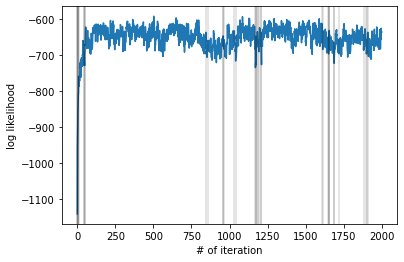

In [396]:
plt.plot(lls)
plt.xlabel("# of iteration")
plt.ylabel("log likelihood")
for s in np.where(all_shifted)[0]:
    plt.axvline(s, color="black", lw=0.2)

### True motif vs. samples

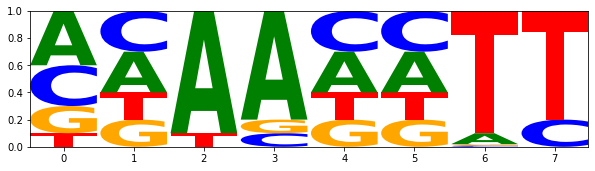

In [397]:
draw_motif(motif)

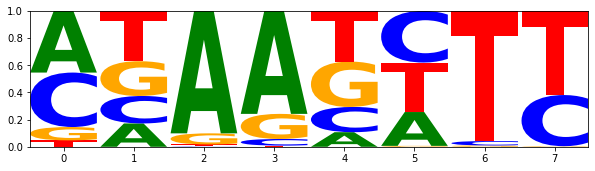

In [403]:
draw_motif(states[500][0])

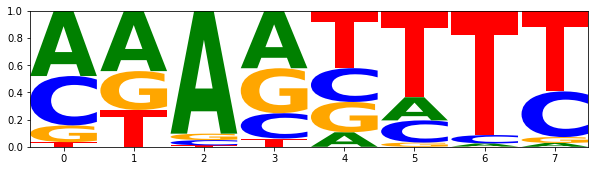

In [404]:
draw_motif(states[1000][0])

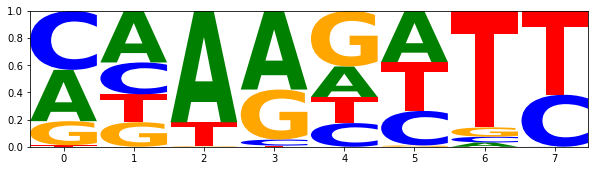

In [405]:
draw_motif(states[1500][0])

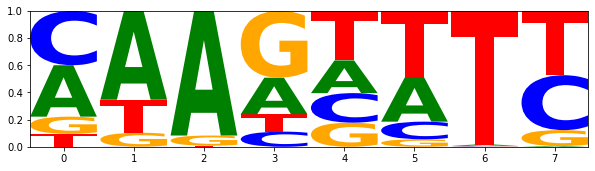

In [406]:
draw_motif(states[1750][0])

## Draw motif according to Dirichlet, estimate it with EM, and MCMC, then try some metrics

In [424]:
import scipy.stats

def motif_total_entropy(motif):
    return scipy.stats.entropy(motif, axis=1).sum()

def study_convergence(
    alpha,
    num_sequences,
    sequence_length,
    motif_length,
    n_iterations,
):
    # Draw motif
    true_motif = draw_motif_from_dirichlet(alpha, motif_length)
    
    # Draw sequences
    sequences, true_positions = generate_sequences_with_single_motif(num_sequences, sequence_length, true_motif)
    
    # Run EM 
    est_motif, lls, positions_posterior_matrices = \
        expectation_maximization(sequences, motif_length, n_iterations, print_every=10)
    
    # Run MCMC without shifts
    _, _, states_no = mcmc_sampling(
        sequences,
        motif_length,
        alpha,
        2000,
        with_shifts=False,
        rng=None,
        print_every=100,
    )

    _, _, states_yes = mcmc_sampling(
        sequences,
        motif_length,
        alpha,
        2000,
        with_shifts=True,
        rng=None,
        print_every=100,
    )
    
    
    
    # Draw true and estimated motifs
    draw_motif(true_motif, "Truth")
    draw_motif(est_motif, "EM")
    draw_motif(states_no[500][0], "MCMC sample, no shifts")
    draw_motif(states_no[1000][0], "MCMC sample, no shifts")
    draw_motif(states_no[1500][0], "MCMC sample, no shifts")
    draw_motif(states_no[-1][0], "MCMC sample, no shifts")
    draw_motif(states_yes[500][0], "MCMC sample, with shifts")
    draw_motif(states_yes[1000][0], "MCMC sample, with shifts")
    draw_motif(states_yes[1500][0], "MCMC sample, with shifts")
    draw_motif(states_yes[-1][0], "MCMC sample, with shifts")
    
    # Print likelihoods
    print("Likelihod of true motif:", log_likelihood(sequences, true_motif))
    print("Likelihod of EM estimated motif:", log_likelihood(sequences, est_motif))
    
    # Print entropies
    print("Entropy of true motif:", motif_total_entropy(true_motif))
    print("Entropy of EM estimated motif:", motif_total_entropy(est_motif))


Iteration 0: LL = -12481.38720498927
Iteration 10: LL = -12433.523013420572
Iteration 20: LL = -12368.736051964272
Iteration 30: LL = -12368.688581086926
Iteration 40: LL = -12368.68858035245
Iteration 50: LL = -12368.688580352435
Iteration 60: LL = -12368.688580352435
Iteration 70: LL = -12368.688580352435
Iteration 80: LL = -12368.688580352435
Iteration 90: LL = -12368.688580352435
Iteration 0: LL = -1225.457174299175
Iteration 100: LL = -304.1914664185729
Iteration 200: LL = -299.51255388165265
Iteration 300: LL = -301.720854828157
Iteration 400: LL = -304.297982789443
Iteration 500: LL = -303.91330760000903
Iteration 600: LL = -300.3623025147292
Iteration 700: LL = -307.2216216064344
Iteration 800: LL = -300.0003969123174
Iteration 900: LL = -309.3104105993996
Iteration 1000: LL = -303.79103242398975
Iteration 1100: LL = -307.71296726436816
Iteration 1200: LL = -304.98151892929155
Iteration 1300: LL = -303.64507663543515
Iteration 1400: LL = -308.42444806110603
Iteration 1500: LL =

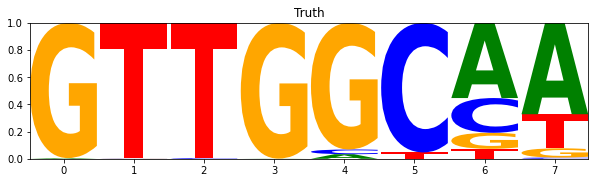

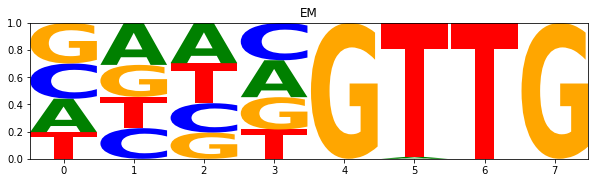

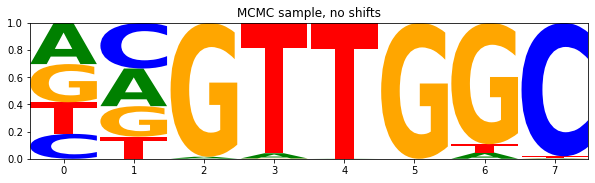

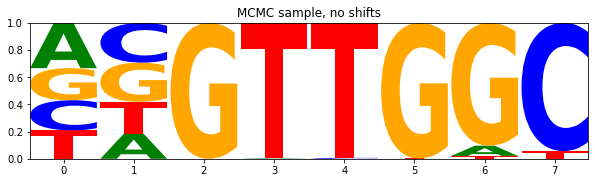

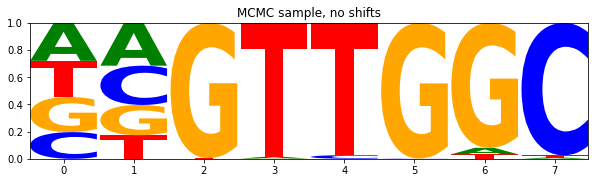

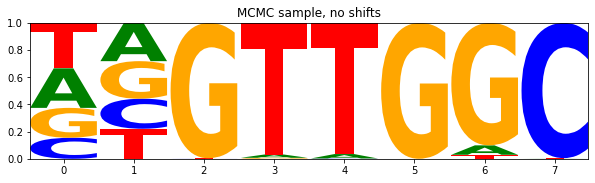

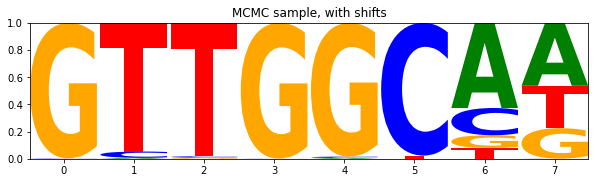

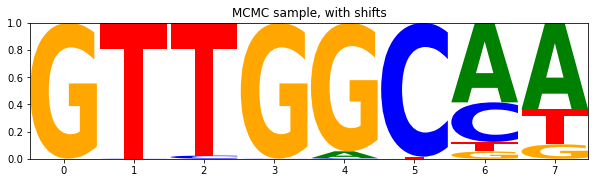

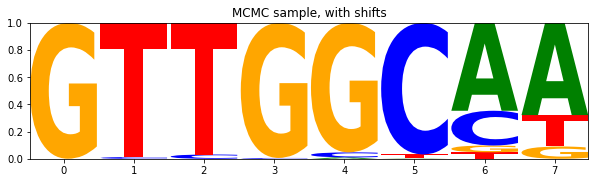

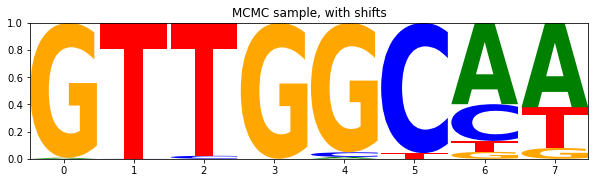

In [426]:
study_convergence(
    alpha = 0.1,
    num_sequences = 90,
    sequence_length = 100,
    motif_length = 8,
    n_iterations = 100,
)

Iteration 0: LL = -12473.886915872632
Iteration 10: LL = -12445.430445934591
Iteration 20: LL = -12399.148527674244
Iteration 30: LL = -12396.85885588881
Iteration 40: LL = -12396.524574671246
Iteration 50: LL = -12396.468915263102
Iteration 60: LL = -12396.45861322875
Iteration 70: LL = -12396.456669085348
Iteration 80: LL = -12396.456303353485
Iteration 90: LL = -12396.45623454156
Iteration 0: LL = -1322.7042216338077
Iteration 100: LL = -679.5956878591861
Iteration 200: LL = -713.5742492385828
Iteration 300: LL = -671.4993210948148
Iteration 400: LL = -682.1330305376742
Iteration 500: LL = -666.0835987123605
Iteration 600: LL = -707.8810417701646
Iteration 700: LL = -661.8970082767037
Iteration 800: LL = -688.427956289433
Iteration 900: LL = -678.5338240509798
Iteration 1000: LL = -612.7375018158306
Iteration 1100: LL = -606.9698035297872
Iteration 1200: LL = -593.3163021198455
Iteration 1300: LL = -618.4301126618949
Iteration 1400: LL = -606.7768458020678
Iteration 1500: LL = -601.

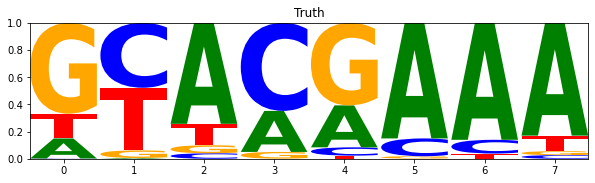

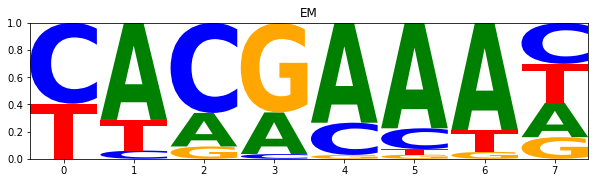

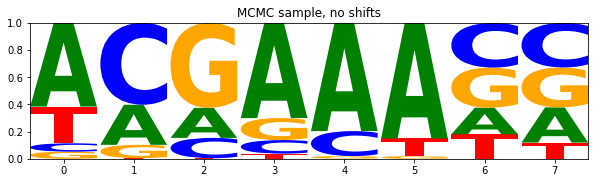

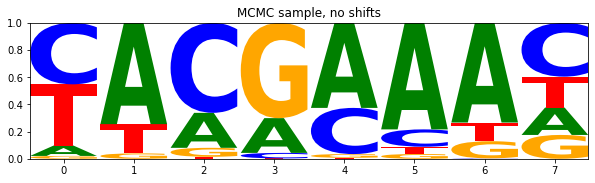

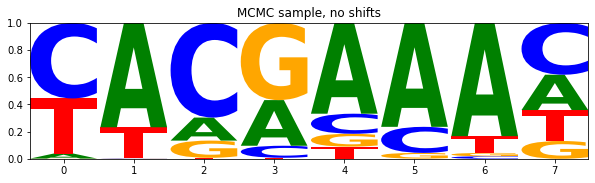

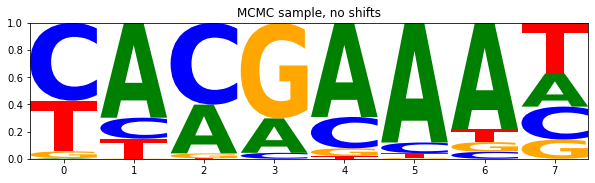

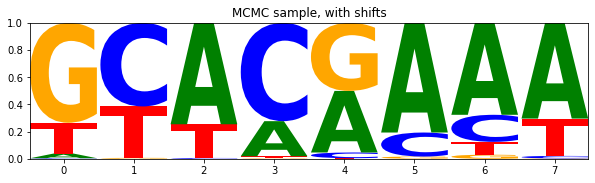

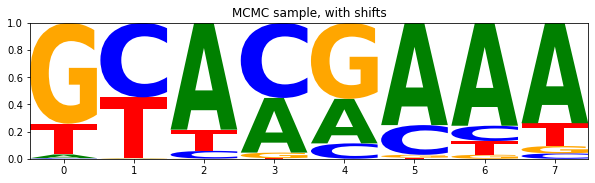

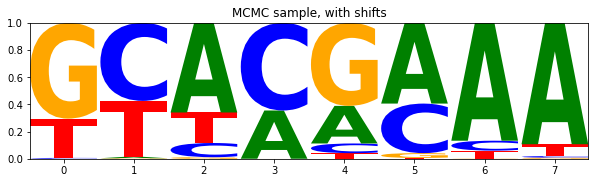

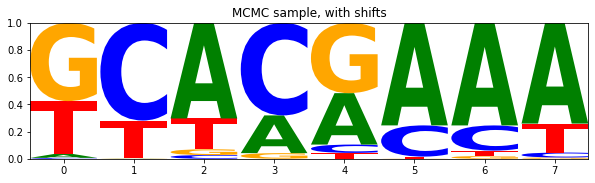

In [428]:
study_convergence(
    alpha = 0.5,
    num_sequences = 90,
    sequence_length = 100,
    motif_length = 8,
    n_iterations = 100,
)

Iteration 0: LL = -12485.491921342511
Iteration 10: LL = -12470.938034997916
Iteration 20: LL = -12459.57793410399
Iteration 30: LL = -12456.997426574262
Iteration 40: LL = -12456.27722929076
Iteration 50: LL = -12455.93003351436
Iteration 60: LL = -12455.705359370508
Iteration 70: LL = -12455.497991832093
Iteration 80: LL = -12455.2934202461
Iteration 90: LL = -12455.116490798764
Iteration 0: LL = -1178.004126043709
Iteration 100: LL = -733.6507780704654
Iteration 200: LL = -768.0236632453503
Iteration 300: LL = -797.568453419207
Iteration 400: LL = -750.7604932329125
Iteration 500: LL = -731.4532258644729
Iteration 600: LL = -776.1699039228959
Iteration 700: LL = -734.1130598267608
Iteration 800: LL = -797.3547406246673
Iteration 900: LL = -739.9433035276326
Iteration 1000: LL = -786.7407028792006
Iteration 1100: LL = -737.9135358318688
Iteration 1200: LL = -762.2893116916632
Iteration 1300: LL = -728.4953152258631
Iteration 1400: LL = -775.4514898021434
Iteration 1500: LL = -763.661

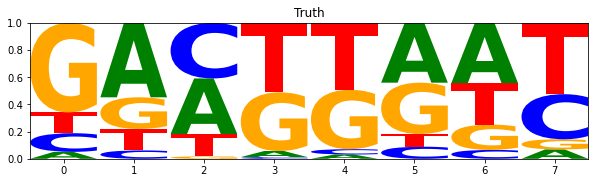

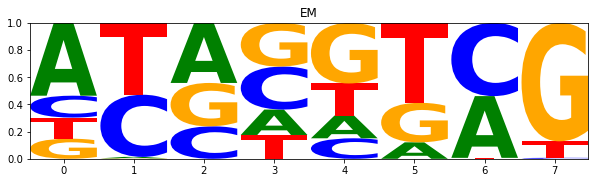

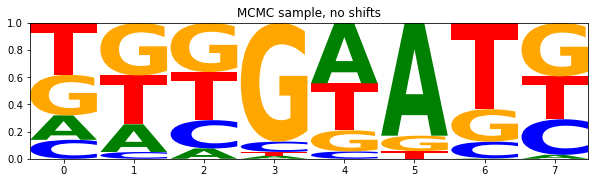

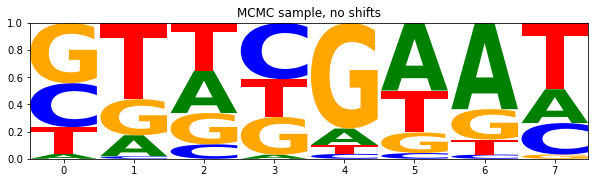

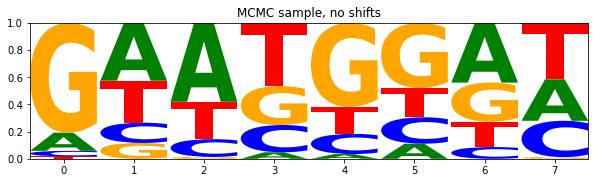

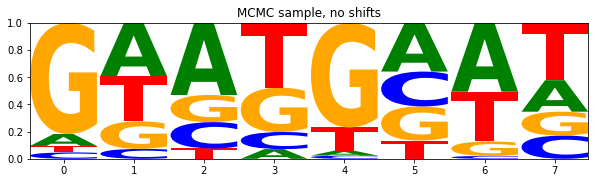

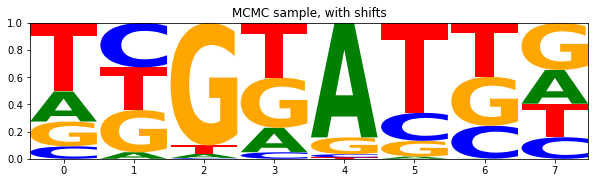

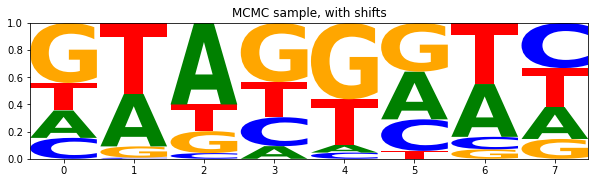

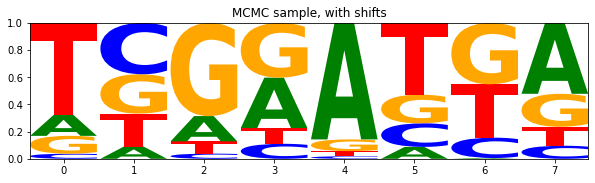

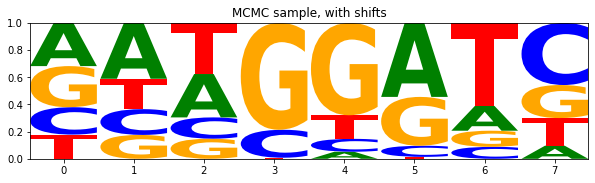

In [427]:
study_convergence(
    alpha = 1,
    num_sequences = 90,
    sequence_length = 100,
    motif_length = 8,
    n_iterations = 100,
)